In [1]:
import utils
import metrics
import CNNLSTMModel
import ConvLSTM2DModel

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

LUCKY_NUMBER = 2
TARGET_SIZE = (16, 16) # For no compression choose -1
TARGET_SLICES = 304
np.random.seed(LUCKY_NUMBER)

PHOTOS_PATH = "E:\\images\\"
MASK_PATH = "E:\\masks\\"

In [2]:
print("GPUs Available: ",tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


Prepare data

In [3]:
scan_names = [file[:8] for file in os.listdir(PHOTOS_PATH) if file.endswith(".nii.gz")]
train, val, test = utils.split_train_val_test(scan_names, 0.7, 0.15, 0.15)
print(f"Training data size: {len(train)}, Validation data size: {len(val)}, Test data size: {len(test)}")

train_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, train)
val_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, val)

epochs = 10
model = CNNLSTMModel.create_cnn_lstm_model(image_shape=TARGET_SIZE, num_slices=TARGET_SLICES)
#model = ConvLSTM2DModel.create_cnn_convlstm2d_model(image_shape=TARGET_SIZE, num_slices=TARGET_SLICES)
model.summary()

print(model.output_shape)

Training data size: 98, Validation data size: 21, Test data size: 21
Model: "CNN_LSTM_Segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 304, 16, 16, 1)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 304, 2048)        92672     
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 304, 128)          1114624   
                                                                 
 lstm_1 (LSTM)               (None, 304, 64)           49408     
                                                                 
 time_distributed_1 (TimeDis  (None, 304, 256)         16640     
 tributed)                                                       
                                          

Train model

In [4]:
model.fit(
    train_gen, 
    steps_per_epoch=len(train),
    #validation_data=val_gen,
    #validation_steps=len(val),
    epochs=epochs)

ZEBY_183_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_183.nii.gz: (1, 304, 16, 16, 1)
Epoch 1/10
ZEBY_218_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_218.nii.gz: (1, 304, 16, 16, 1)
22/98 [=====>........................] - ETA: 5:56 - loss: 0.9727 - jaccard_index: 0.0348 - dice_coefficient: 0.0273ZEBY_119_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_119.nii.gz: (1, 304, 16, 16, 1)
ZEBY_162_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_162.nii.gz: (1, 304, 16, 16, 1)
24/98 [======>.......................] - ETA: 5:47 - loss: 0.9709 - jaccard_index: 0.0395 - dice_coefficient: 0.0291ZEBY_175_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_175.nii.gz: (1, 304, 16, 16, 1)
ZEBY_102_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_102.nii.gz: (1, 304, 16, 16, 1)
25/98 [======>.......................] - ETA: 5:44 - loss: 0.9721 - jaccard_index: 0.0383 - dice_coefficient: 0.0279ZEBY_157_0000.nii.gz: (1, 304, 16, 16, 1), ZEBY_157.nii.gz: (1, 304, 16, 16, 1)


KeyboardInterrupt: 

In [4]:
utils.save_model(model)

Saving model...
Model saved to models/CNN-LSTM-teeth-segmentation-model-12-04-2024-17-03.keras
Saving history...
History saved to models/history-12-04-2024-17-03.json


Make prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


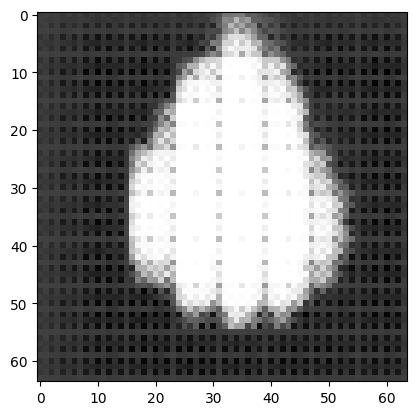

In [5]:
test_scan = utils.load_nifti_cbct_scan(PHOTOS_PATH+train[1]+"_0000.nii.gz")
test_scan = test_scan[..., np.newaxis]
test_scan = np.expand_dims(test_scan, axis=0)

predictions = model.predict(test_scan)

predicted_mask = predictions[0]

binary_mask = (predicted_mask > 0.5).astype(np.float32)

print(predicted_mask[200,:,:,0] == predicted_mask[300,:,:,0])

plt.imshow(predicted_mask[120, :, :, 0], cmap="gray")

Plot results

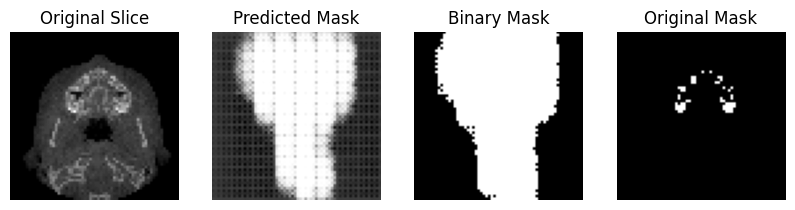

In [9]:
slice_index = 300

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("Original Slice")
plt.imshow(test_scan[0, slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Binary Mask")
plt.imshow(binary_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

original_mask = utils.load_nifti_mask(MASK_PATH+train[1]+".nii.gz")
plt.subplot(1, 4, 4)
plt.title("Original Mask")
plt.imshow(original_mask[slice_index,:,:], cmap="gray")
plt.axis('off')
plt.show()